# Preliminaries - Installs, imports etc.

In [87]:
#@title Choose seed value
Seed = 1995 #@param {type:"integer"}
!rm -rf ./logs/
%load_ext tensorboard
%matplotlib inline

import datetime
import numpy as np
from numpy.random import Generator, PCG64
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics.pairwise import cosine_distances
from IPython.display import clear_output
from random import randrange,sample,seed

tf.random.set_seed(Seed)  # Seeding Tensorflow.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# MNIST Dataset - Loading & Preprocessing

In [88]:
num_classes = 10
img_rows, img_cols, img_colors = 28, 28, 1  # Greyscale images of 28 X 28.


(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

# Utils

In [89]:
def extract_conv_weights(model, conv_layers_indices):
  all_weights: list = list()
  for layer in model.layers[conv_layers_indices]:
    all_weights.append(layer.weights[0].numpy())  # Taking only the filters, not the biases.
  return all_weights

def plot_all_filters(all_weights):
  cols_num: int = 4
  for layer_ind, layer_filters in enumerate(all_weights):
    print(layer_filters.shape)
    filters_num: int = layer_filters.shape[3]
    fig, axs = plt.subplots(int(np.ceil(filters_num/cols_num)), cols_num)
    fig.suptitle(f'Conv. layer no. {layer_ind + 1}')
    for image_index in range(filters_num):
      current_axs = axs[int(np.floor(image_index/cols_num)), image_index % cols_num]
      current_axs.set_title(f'Filter no. {image_index}')
      current_axs.imshow(layer_filters[:,:,0,image_index])

  plt.show()

def calc_dist_mat(all_weights):  
  all_dist_mats: list = list()
  for layer_ind, layer_filters in enumerate(all_weights):
    filters_num: int = np.prod(layer_filters.shape[2:])
    weights_samples = layer_filters.reshape((9, filters_num)).T

    # Use Scikit-Learn's function for cosine-distances computation.
    distances_mat = cosine_distances(weights_samples)
    all_dist_mats.append(distances_mat.copy())
  return all_dist_mats

# Models For Investigation

In [90]:
def score_predict(model,test_images, test_labels):
    score = model.evaluate(test_images, test_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Test accuracy: {:.2f}'.format( score[1]))
    
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))

def CNN_mnist_model(img_rows, img_cols, img_colors,num_classes,selected_model="CNN from Lecture 2"):
    activation = 'relu'
    model = keras.Sequential(name = selected_model.replace(" ", "_"))
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adadelta(),
                metrics=[keras.metrics.CategoricalAccuracy()])
    conv_layers_indices = slice(0, 2)
    return model, conv_layers_indices


def ANN_mnist_model(img_rows, img_cols, img_colors,num_classes,learning_rate,selected_model="NN from Ex 1"):

    model = keras.Sequential(name = selected_model.replace(" ", "_"))
    model.add(layers.Flatten(input_shape=(img_rows, img_cols, img_colors)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=[keras.metrics.CategoricalAccuracy()])
    return model
        

def train_model(model,max_epochs: int, train_images, train_labels,test_images, test_labels,batch_size,callbacks_list,verbose=1):
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(train_images, train_labels,
        batch_size=batch_size,
        epochs=max_epochs,
        verbose=verbose,
        validation_data=(test_images, test_labels),
        callbacks=callbacks_list)
    return history


In [91]:
#@title Select The Model to Attack and Hyperparameters
selected_model = "CNN from Lecture 2" #@param ["CNN from Lecture 2", "NN from Ex 1"]
batch_size = 128 #@param {type:"integer"}
max_epochs = 15 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
lr_decay = 1e-6 #@param {type:"number"}
lr_drop = 6 #@param {type:"number"}
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

In [92]:
if selected_model == "CNN from Lecture 2":
  model, conv_layers_indices = CNN_mnist_model(
      img_rows, img_cols, img_colors, num_classes, 
      selected_model="CNN from Lecture 2")
  callbacks_list = [tensorboard_callback, reduce_lr]

# Complete-Analysis Function

In [93]:
def analyze_model(model, conv_layer_indices):
  all_weights = extract_conv_weights(model, conv_layers_indices)
  plot_all_filters(all_weights)  # Taking all the conv. weights (without biases).
  dist_matrices = calc_dist_mat(all_weights)  # Compute cosine-distances matrix for each conv. layer.

  for i, dist_matrix in enumerate(dist_matrices):
    print(f'Conv. layer no. {i}')

    # Estimate mean of cosine-distances in this layer.
    distances_sum = np.sum(dist_matrix, axis=(0, 1))
    filters_num = dist_matrix.shape[0]
    pairs_count = filters_num ** 2 - filters_num  # No counting for pairs of identical filters.
    distances_mean = distances_sum / pairs_count
    print(f'Mean distance between filters: {distances_mean}')

    # Plot cosine-distances matrix.
    plt.figure()
    plt.title(f'Cosine-Distances Plot')
    sns.heatmap(dist_matrix, annot=True)

# All Results

## Perform The Filters Analysis BEFORE Training

Model: "CNN_from_Lecture_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 12, 12, 8)         0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 12, 12, 8)         0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               147584    
_________________________________________________________________
dropout_65 (Dropout)         (None, 128)        

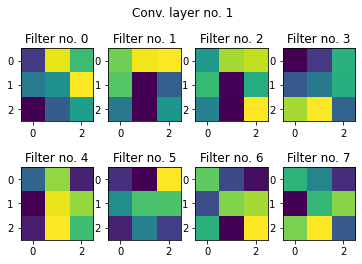

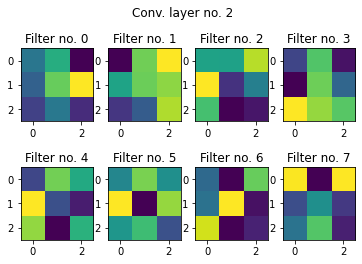

Conv. layer no. 0
Mean distance between filters: 1.0212508610316686
Conv. layer no. 1
Mean distance between filters: 1.0039159381200398


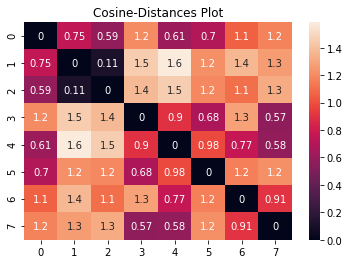

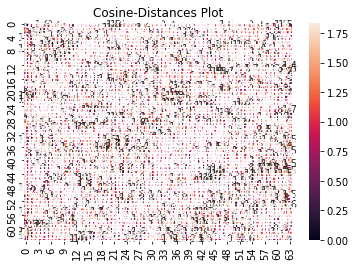

In [94]:
# Plot model and its filters BEFORE training
model.summary()
analyze_model(model, conv_layers_indices)
plt.show()

## Train The Model and Repeat The Analysis of Filters

Epoch 1/15
469/469 [==============================] - 3s 6ms/step - loss: 1.5282 - categorical_accuracy: 0.4887 - val_loss: 0.3028 - val_categorical_accuracy: 0.9194
Epoch 2/15
469/469 [==============================] - 2s 4ms/step - loss: 0.4757 - categorical_accuracy: 0.8552 - val_loss: 0.2187 - val_categorical_accuracy: 0.9378
Epoch 3/15
469/469 [==============================] - 2s 4ms/step - loss: 0.3581 - categorical_accuracy: 0.8925 - val_loss: 0.1791 - val_categorical_accuracy: 0.9485
Epoch 4/15
469/469 [==============================] - 2s 4ms/step - loss: 0.3063 - categorical_accuracy: 0.9099 - val_loss: 0.1512 - val_categorical_accuracy: 0.9554
Epoch 5/15
469/469 [==============================] - 2s 4ms/step - loss: 0.2733 - categorical_accuracy: 0.9186 - val_loss: 0.1321 - val_categorical_accuracy: 0.9611
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.2475 - categorical_accuracy: 0.9270 - val_loss: 0.1182 - val_categorical_accuracy: 0.9642
Epoc

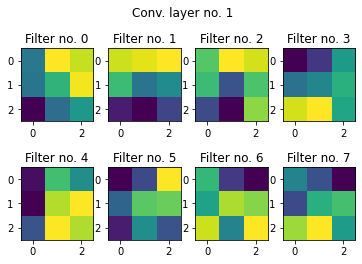

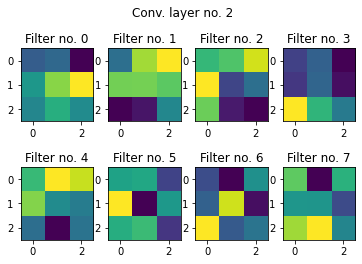

Conv. layer no. 0
Mean distance between filters: 0.8515280314854213
Conv. layer no. 1
Mean distance between filters: 1.0034951709565663


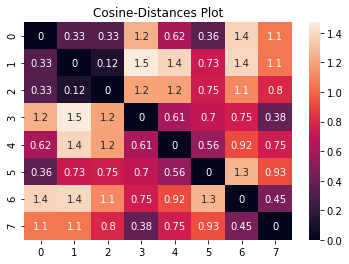

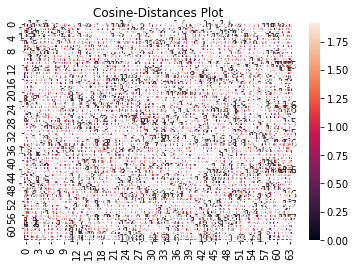

In [95]:
# Train model and perform the analysis once-mnore
history = train_model(model, max_epochs, train_images, train_labels,
                      test_images, test_labels, batch_size, callbacks_list)
analyze_model(model, conv_layers_indices)
plt.show()